#### bayes classification project
##### as a input line of a poem will be given to the model and using markov model and bayes classifiers concept we will predict that this poem is written by robert frost or edger allen
1. make two dataframe of sentences by robert frost and edger allen
2. then split the data frame into train and  test split
3. train dataset will be used to make the markov model for each poet 
4. using testing dataset we will try to predict the poet name by finding the probability of the sentences using that markov model


### import all necessary library

In [17]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re

#### storing two robert frost and edger allen poem in different variable for further process

In [18]:
with open('edger_allen.txt','r') as f:
    edgerfile=f.read()

In [19]:
with open('robert_frost.txt','r') as f:
    roberfile=f.read()

### in this phase all the punctuation are removed from the text document, then splitted into sentences  and stored in pandas dataframes

In [20]:
def creating_dataframe(string):
    # print(string[:100])
    
    string= string.replace(",", "")
    string=string.replace("â€‰","")
    string=string.replace("!","")
    string=string.replace("-"," ")
    string=string.replace(";"," ")
    string=string.replace("."," ")
    string=string.replace(":"," ")
    string=string.replace("("," ")
    string=string.replace(")"," ")
    string=string.replace("'"," ")
    string=string.replace('"'," ")
    string=string.replace('?'," ")
    
    
    sentToken=string.lower().splitlines()
    return pd.DataFrame(sentToken,columns=['poemINsent'])
    # print(type(sentToken))
    # print(len(sentToken))
    # for sent in sentToken:
    #     print(sent)
    #     print("___________________________________________________________________")
df_edger_allen=creating_dataframe(edgerfile)
df_robert_frost=creating_dataframe(roberfile)


### removing rows which contains empty sentences

In [21]:
df_edger_allen=df_edger_allen.loc[df_edger_allen['poemINsent']!=""]
df_robert_frost=df_robert_frost.loc[df_robert_frost['poemINsent']!=""]


In [22]:
df_edger_allen=df_edger_allen[['poemINsent']]
df_robert_frost=df_robert_frost[['poemINsent']]

In [23]:
df_robert_frost

,poemINsent
0,two roads diverged in a yellow wood
1,and sorry i could not travel both
2,and be one traveler long i stood
3,and looked down one as far as i could
4,to where it bent in the undergrowth
...,...
1575,to say which buds are leaf and which are bloom
1577,a feather hammer gives a double knock
1578,this eden day is done at two o clock
1579,an hour of winter day might seem too short


In [24]:
df_edger_allen


,poemINsent
0,lo death hath rear d himself a throne
1,in a strange city all alone
2,far down within the dim west
3,where the good and the bad and the worst and t...
4,have gone to their eternal rest
...,...
792,to a discordant melody
793,while like a rapid ghastly river
794,through the pale door
795,a hideous throng rush out forever


In [25]:
tagging={'J':wordnet.ADJ,
        'V':wordnet.VERB,
        'N':wordnet.NOUN,
        'R':wordnet.ADV}
def getword_pos(treebank_tag):
    if treebank_tag[0] in tagging:
        return tagging[treebank_tag[0]]
    else:
        return tagging['N']

##### to tokenize the given document and to transform all the word to their present form i have used WordNetLemmatizer() class where i have to provide each word and corrspoding part of speech tag. 
##### e.g lemmatize('aditya',wordnet.NOUN) , to give this tag automatically to every word i have used nltk.pos_tag() which will tag every word with name like these ["JJ","NN","CC","VBP","RB","PRP$","VBZ"]
##### but WordNetLemmatizer() class will take 'pos' tag in the form of wordnet.NOUN,wordnet.ADJ like these so for that getword_pos() function is used which is defined above 


In [26]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        token=word_tokenize(doc)
        word_and_tag=nltk.pos_tag(token)
        return[self.wnl.lemmatize(word,pos=getword_pos(tag)) for word, tag in word_and_tag]

##### in below function each text sentence from pandas dataframe are tokenize with previously defined LemmaTokenizer class and after that i am assigning a  numerical value to each token and storing it into a list 
##### this function return a dictionary which contains  pairs of token and its id
##### a dictionary of id:token pair 
##### list of list of id for each sentences of data frames for further process and to build markov model
##### and in this mapping of token to id , each token is mapped to a unique id and each id is also mapped to a unique token 

In [27]:
def lemmatize_and_assign_tokenId(df,content):
    inx=0
    wordToInd={}
    tokenlist=[]
    wnl=LemmaTokenizer()
    for ind,row in df.head(700).iterrows():
        curlist=[]
        
        for token in wnl(row[content]):
            if token not in wordToInd:
                wordToInd[token]=inx
                inx+=1
            curlist.append(wordToInd[token])
        tokenlist.append(curlist)
        
    IndToWord={v:k for k,v in wordToInd.items()}

    return wordToInd,tokenlist,IndToWord,inx
wordToInd_edger,list_tokenId_edger,indToWord_edger,maxind_edger=lemmatize_and_assign_tokenId(df_edger_allen,'poemINsent')
wordToInd_robert,list_tokenId_robert,indToWord_robert,maxind_robert=lemmatize_and_assign_tokenId(df_robert_frost,'poemINsent')    
    

In [28]:
maxind_edger,maxind_robert

(1074, 1164)

In [ ]:
wordToInd_edger,tokenId_edger,indToWord_edger,maxind

#### creating a marcov model where a 2D matrix is used to store no of occurrence of each consecutive two word together . it means as  row index all token are there which has already occur and each column index token  represent how many times it has occurred given that row index token has already occur
#### this funciton also return a list which contains no of times each first word of the sentences occur in first position in entire dataset. which is called PI


In [29]:
def create_markov(listoftokenid,maxind):
    PI=np.zeros(maxind)
    marcovModel=np.zeros((maxind,maxind))
    
    for ind, row in enumerate(listoftokenid):
        PI[row[0]]+=1
        for i in range(len(row)-1):
            marcovModel[row[i],row[i+1]]+=1
    return PI,marcovModel
    
PI_edger,A_marcov_edger=create_markov(list_tokenId_edger,maxind_edger)
PI_robert,A_marcov_robert=create_markov(list_tokenId_robert,maxind_robert)

In [30]:
percentageOFNONzero_edger=(A_marcov_edger!=0).sum()/np.multiply(A_marcov_edger.shape[0],A_marcov_edger.shape[1])
percentageOFNONzero_robert=(A_marcov_robert!=0).sum()/np.multiply(A_marcov_robert.shape[0],A_marcov_robert.shape[1])
percentageOFNONzero_edger,percentageOFNONzero_robert

(0.0022410522628992713, 0.0026725298473093137)

##### spliting the dataset  into training and testing dataset

In [31]:
test_edger,test_robert=list_tokenId_edger[-50:],list_tokenId_robert[-50:]
train_edger,train_robert=list_tokenId_edger[:300],list_tokenId_robert[:300]

##### smoothing the marcov matrix and PI list by adding a value 1 

In [32]:
## smooting of the frequency value
PI_edger+=1
PI_robert+=1
A_marcov_edger+=1
A_marcov_robert+=1

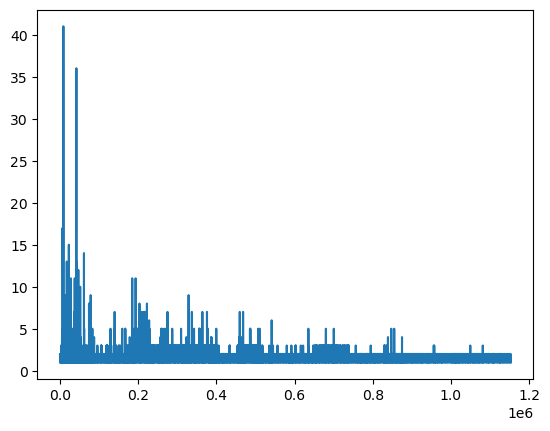

In [33]:
import matplotlib.pyplot as plt
distribution=A_marcov_edger.copy()
plt.plot(distribution.reshape(-1))

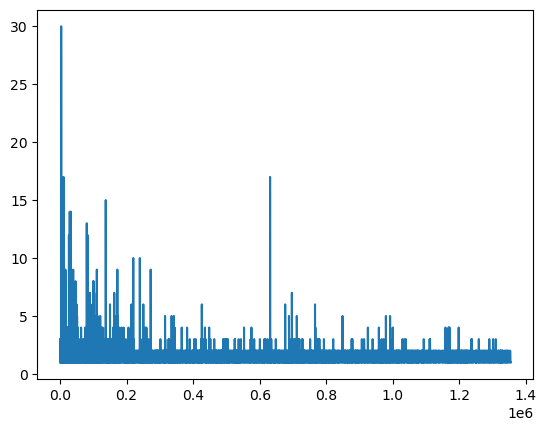

In [34]:
import matplotlib.pyplot as plt
distribution=A_marcov_robert.copy()
plt.plot(distribution.reshape(-1))

##### normalizing the each value of the marcov model by deviding each value of a row by the summation of each value in that raw which will give us probability of occurrence of column token where corresponding row token index has already occur

In [35]:
## calculating the probability value each each matrix element
PI_edger_prob=PI_edger/PI_edger.sum()
PI_robert_prob=PI_robert/PI_robert.sum()
A_marcov_edger_prob=A_marcov_edger/A_marcov_edger.sum(axis=1,keepdims=True)
A_marcov_robert_prob=A_marcov_robert/A_marcov_robert.sum(axis=1,keepdims=True)


In [36]:
print(PI_edger_prob)
print('_______________________________')
print(PI_robert_prob)
print('_______________________________')

print(A_marcov_edger_prob)
print('_______________________________')

print(A_marcov_robert_prob)
print('_______________________________')


[0.0011274  0.0011274  0.00338219 ... 0.0005637  0.0005637  0.0005637 ]
_______________________________
[0.0026824  0.00053648 0.00053648 ... 0.00053648 0.00053648 0.00053648]
_______________________________
[[0.00092937 0.00185874 0.00092937 ... 0.00092937 0.00092937 0.00092937]
 [0.00092851 0.00092851 0.00185701 ... 0.00092851 0.00092851 0.00092851]
 [0.00092251 0.00092251 0.00092251 ... 0.00092251 0.00092251 0.00092251]
 ...
 [0.0009311  0.0009311  0.0009311  ... 0.0009311  0.0009311  0.0009311 ]
 [0.00093023 0.00093023 0.00093023 ... 0.00093023 0.00093023 0.00093023]
 [0.00093023 0.00093023 0.00093023 ... 0.00093023 0.00093023 0.00093023]]
_______________________________
[[0.00085179 0.00255537 0.00085179 ... 0.00085179 0.00085179 0.00085179]
 [0.0008547  0.0008547  0.0025641  ... 0.0008547  0.0008547  0.0008547 ]
 [0.00085763 0.00085763 0.00085763 ... 0.00085763 0.00085763 0.00085763]
 ...
 [0.00085911 0.00085911 0.00085911 ... 0.00085911 0.00085911 0.00085911]
 [0.00085837 0.0008

##### in this phase all marcov matrix values and PI list value are amplified by using log function because each original value are so small which is hard to stored in computer memory  which eventually create error in further calculation.

In [37]:
## logarithmic value
log_PI_edger=np.log(PI_edger_prob)
log_PI_robert=np.log(PI_robert_prob)
log_A_edger=np.log(A_marcov_edger_prob)
log_A_robert=np.log(A_marcov_robert_prob)


## testing of the marcov model


#### testing the last 50 rows of robert frost poem and edger allen poem 
#### in this testing process we have to predict that input poem belongs to robert frost and edger allen


In [40]:
print(test_robert[:10])
print("++++++++++++++++++++++")
print(test_edger[:10])

[[361, 27, 1081, 95, 14, 120, 176, 1127], [27, 56, 1057, 23, 388, 27, 872, 1047], [9, 664, 47, 1048, 841, 295, 385, 23, 664, 47], [1128, 9, 1129, 23, 27, 852, 7, 153, 27, 1067], [1048, 461, 1031, 9, 86, 451, 1031, 27, 852, 763], [7, 1030, 27, 1029, 118, 27, 675, 220, 25], [29, 617, 124, 14, 46, 839], [103, 872, 44, 617, 328, 73, 40, 270], [27, 872, 14, 84, 23, 853, 249, 27, 1035], [71, 27, 648, 234, 27, 872, 288, 47, 34, 25]]
++++++++++++++++++++++
[[47, 16, 1018, 21, 16, 1019, 1020, 363], [133, 162, 8, 281], [16, 296, 39, 192], [34, 1021, 36, 16, 557], [21, 16, 1022, 1023, 39, 172, 438], [57, 16, 1024, 415, 39, 816, 1025], [34, 725, 256, 6, 1010], [15, 16, 218], [171, 553, 1026], [39, 263, 172, 652, 155, 242]]


#### to classify the poem between two category bayes theorm is used here. and since the formula for bayes theorm is
1. probability of poem belongs to robert frost is denoted like this Prob(robert_frost/poem)=prob(poem/robert_frost)xProb(robert_frost)
2. probability of poem belongs to edger allen is denoted like this Prob(edger_allen/poem)=prob(poem/edger_allen)xprob(edger_allen)
3. since pecentage of data set we have taken for trainig the marcov model for each poet is same so prob(robert_Frost) and prob(edger_allen) is 1/2 which is also can be ignored because at the the end it is the relative value which will decide the category of the poem.
4. and to calculate prob(poem/rober_frost) and prob(poem/edger allen) below methodlogy is used

5. i will select all the consecutive token value of input poem and find the corresponding marcov model value . after this we will mulitply all these value but since these matrix values are passed through the log fun so  instead of multipication we will add each found value for each consecutive token id. 
6. we also add PI value of each first token id of a sentence 
7. these process is repeated for both the marcov model :robert frost and edger allen
8. then if prob is high from a model then poem belongs to that poet

In [42]:
def prob_of_belonging_of_a_poem(poem):
    inf_edger=[]
    inf_robert=[]
    for sent in poem:
        if sent[0] in indToWord_edger:
            curinf_edger=log_PI_edger[sent[0]]
        else:
            curinf_edger=0
        if sent[0] in indToWord_robert:
            curinf_robert=log_PI_robert[sent[0]]
        else:
            curinf_robert=0
        for ind in range(len(sent)-1):

            if (sent[ind]  in indToWord_edger) and (sent[ind+1] in indToWord_edger):
                curinf_edger+=log_A_edger[sent[ind],sent[ind+1]]

            else:
                curinf_edger+=0
            if (sent[ind] in indToWord_robert) and (sent[ind+1] in indToWord_robert):
                curinf_robert+=log_A_robert[sent[ind],sent[ind+1]]
            else:
                curinf_robert+=0
        inf_edger.append(curinf_edger)
        inf_robert.append(curinf_robert)
    return inf_edger,inf_robert    
    
        
        
        
    

In [46]:
def fun_classification(row):
    
    if row['edger_marcov_inf']<row['robert_marcov_inf']:
        return "robert"
    else:
        return "edger"

#### testing edger Poem

In [52]:
inf_edger,inf_robert=prob_of_belonging_of_a_poem(test_edger)
inference_df_edger=pd.DataFrame(inf_edger,columns=['edger_marcov_inf'])
inference_df_robert=pd.DataFrame(inf_robert,columns=['robert_marcov_inf'])
inference_df=pd.concat([inference_df_edger,inference_df_robert],axis=1)
inference_df['category']=inference_df.apply(fun_classification ,axis=1)
inference_df.value_counts('category')

category
edger    50
Name: count, dtype: int64

#### testing robert frost poem

In [51]:
inf_edger,inf_robert=prob_of_belonging_of_a_poem(test_robert)
inference_df_edger=pd.DataFrame(inf_edger,columns=['edger_marcov_inf'])
inference_df_robert=pd.DataFrame(inf_robert,columns=['robert_marcov_inf'])
inference_df=pd.concat([inference_df_edger,inference_df_robert],axis=1)
inference_df['category']=inference_df.apply(fun_classification ,axis=1)
inference_df.value_counts('category')

category
edger     27
robert    23
Name: count, dtype: int64